In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline

In [2]:
# to load data
data= pd.read_csv(os.path.join('data1.csv'))

In [ ]:
def dataclean(data):
  # max_value = []
  # min_value = []
  # 'data' is a pandas datafram
  #first 40 rows and 8 columns is training data
  # X, y = data[:,1:],data[:,0].reshape(data.shape[0],1)

  # for i in range(8):
  #     min_value.append(np.min(X[:,i]))
  #     max_value.append(np.max(X[:,i]))

  #     X[:,i] = (X[:,i]-min_value[i]) / (max_value[i]-min_value[i])
  # X = np.concatenate((X,np.ones((data.shape[0],1))), axis =1)
  d = data.to_numpy()
  y = d[:,0]
  d1 = data.drop('angle', 1)
  d2 = d1.drop('P^2',1)

  def min_max_scale(col):
    return  (col - col.min())/(col.max()-col.min())

  for c in d2.columns:
    d2[c] = min_max_scale(d2[c])
    
  X = d2.to_numpy()  
  return X,y
  #pass

In [3]:
d = data.to_numpy()

In [4]:
y = d[:,0]

In [5]:
X = d[:,1:9]

In [ ]:
X,y = dataclean(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [6]:
data2 = pd.read_csv(os.path.join('data.csv'))

In [7]:
d1 = data2.to_numpy()
y1 = d1[:,0]
X1 = d1[:,1:9]

In [8]:
#Implement the activation function
def af(z):
  return (abs(z)+z)/2

In [9]:
#implement the gradient of ReLu function
def grad_af(z):
  return (z + np.abs(z))/(2*np.abs(z))     

In [ ]:
# tanh activation
def tanh(z):
  num  = ()

In [34]:
# Gaussian parameters
mu = 0.7
sigma = 1

In [20]:
# Gaussian distrinution
def normal(x):
  z = (x - mu)/sigma
  return np.exp(-1*(z**2))

In [21]:
# gradient of gaussian
def grad_normal(x):
  z = (x-mu)/sigma
  return (-2)*(z)*np.exp(-1*(z**2))

In [12]:
epsilon = 0.1
input_layer_size  =  8 
hl1 = 37
hl2 = 29
output_layer_size =  1   

In [13]:
#randomly initialise weights.
def randInitializeWeights(L_in, L_out, epsilon_value = 0.10):
    W= np.zeros((L_out, L_in+1))
    W= (np.random.rand(L_out, L_in+1)*2*epsilon)-epsilon
    return W

In [14]:
# for 2 hiddeh layers
initial_w1h2 = randInitializeWeights(input_layer_size,hl1)
initial_w2h2 = randInitializeWeights(hl1,hl2)
initial_w3h2 = randInitializeWeights(hl2,output_layer_size)
# Unroll parameters into a single array
initial_nn_params_h2 = np.concatenate([initial_w1h2.ravel(), initial_w2h2.ravel(), initial_w3h2.ravel()], axis=0)

Analytical solution 
P, is taken to be at the centroid of the
cross-section of the air chamber, e is the distance from the centroid
of the actuator cross-section to the center of pressure, Li is initial length, A is the area of the cross-section of the chamber, and Aw
is the area of the cross-section of the actuator. E is modolus of elasticity derieved from the elastic energy density function, differentiating the energy to get modulus. **Note: calucation to be done in SI units only**

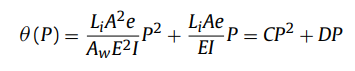
this solution assumes that the 'E' of material is constant.

In [ ]:
def analytic_soln(Li, A, Aw, E, I, e, P):
  D = (Li)*(A)*(e)/(E*I)
  C = (D*A)/(Aw*E)
  return C*(P**2) + D*P

In [ ]:
# for variation of parameters separate errors calculated:

# for variation of pressue:
theta_p = 


In [ ]:
# error calculations wrt analytical solution


In [42]:
#Implement the sigmoid function
def sigmoid(z):
  pass
  g = 1/(1+np.exp(-1*z))
  return g

In [43]:
#implement the gradient of the sigmoid function
def sigmoidGradient(z):
  pass
  a = sigmoid(z)
  g = a*(1-a)
  return g

In [15]:
def p2hl(w1, w2, w3, X): 
  if X.ndim==1:
    X=X[None]
  
  m=X.shape[0]
  num_labels= w3.shape[0]
  a1= np.concatenate([np.ones((m,1)), X], axis=1) #Input layer
  a2= sigmoid(a1.dot(w1.T)) #Hidden Layer
  a2= np.concatenate([np.ones((a2.shape[0],1)), a2 ], axis=1) #Activation of 2nd layer
  a3= sigmoid(a2.dot(w2.T))
  a3= np.concatenate([np.ones((a3.shape[0],1)), a3 ], axis=1) #Activation of 3rd layer
  a4 = a3.dot(w3.T)
  p= a4
  return p

In [46]:
def nnCF(nn_params, input_layer_size, hl1, hl2, output_layer_size,
         X, y, lambda_=0.0):

  n0 = input_layer_size
  n1 = hl1
  n2 = hl2
  n3 = output_layer_size
  w1 = np.reshape(nn_params[: n1*(n0 +1)],(n1,n0 +1))
  w2 = np.reshape(nn_params[n1*(n0 +1): n1*(n0 +1) + n2*(n1 +1)], (n2,n1 +1))
  w3 = np.reshape(nn_params[n1*(n0 +1) + n2*(n1 +1) :], (n3,n2 +1))

  m = y.size
  J = 0
  w1_grad = np.zeros(w1.shape)
  w2_grad = np.zeros(w2.shape)
  w3_grad = np.zeros(w3.shape)

  # Activation function and its gradient
  # af = 
  # grad_af = 
    
  a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
  a2 = sigmoid(a1.dot(w1.T))
  a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
  a3 = normal(a2.dot(w2.T))
  a3 = np.concatenate([np.ones((a3.shape[0], 1)), a3], axis=1)
  a4 = af(a3.dot(w3.T))
  y = np.reshape(y,(m,1))

  # Storing values
  t1 = w1
  t2 = w2
  t3 = w3
    
  # Add regularization term  
  reg_term = (lambda_ / (2 * m)) * (np.sum(np.abs(t1[:, 1:])) + np.sum(np.abs(t2[:, 1:])) + np.sum(np.abs(t3[:, 1:])))  
  J = np.sum((a4-y)**4)/(4*m) + reg_term

  # Backpropogation
  delta_4 = 4*((a4 - y)**3)   # Error of O/P layer
  delta_3 = delta_4.dot(w3)[:, 1:] * grad_normal(a2.dot(w2.T)) # Error of hidden layer 2
  delta_2 = delta_3.dot(w2)[:, 1:] * sigmoidGradient(a1.dot(w1.T)) # Error of hidden layer 1

  # Numerical value of error as with dot product with corresponding activation
  Delta1 = delta_2.T.dot(a1)
  Delta2 = delta_3.T.dot(a2) 
  Delta3 = delta_4.T.dot(a3)
    
  # Add regularization to gradient

  w1_grad = (1 / m) * Delta1
  w1_grad[:, 1:] = w1_grad[:, 1:] + (lambda_ / m) * w1[:, 1:]
  w2_grad = (1 / m) * Delta2
  w2_grad[:, 1:] = w2_grad[:, 1:] + (lambda_ / m) * w2[:, 1:]
  w3_grad = (1 / m) * Delta3
  w3_grad[:, 1:] = w3_grad[:, 1:] + (lambda_ / m) * w3[:, 1:]
    
  grad = np.concatenate([w1_grad.ravel(), w2_grad.ravel(),w3_grad.ravel()])
  return J,grad

In [ ]:
options= {'maxiter': 100000}
lambda_ = 0

costFunction = lambda p: nnCF(p, input_layer_size, hl1,hl2, output_layer_size, X, y, lambda_)

li = []
i = 1
def callbackF(xi):
  global i
  li.append(costFunction(xi)[0])


res = optimize.minimize(costFunction,
                        initial_nn_params_h2,
                        jac=True,
                        method='BFGS',callback = callbackF, options = options)

print(res)
nn_params = res.x

n0 = input_layer_size
n1 = hl1
n2 = hl2
n3 = output_layer_size
w1h2 = np.reshape(nn_params[:n1*(n0 +1)],(n1,n0 +1))
w2h2 = np.reshape(nn_params[n1*(n0 +1): n1*(n0 +1) + n2*(n1 +1)], (n2,n1 +1))
w3h2 = np.reshape(nn_params[n1*(n0 +1) + n2*(n1 +1) :], (n3,n2 +1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Desired error not necessarily achieved due to precision loss.


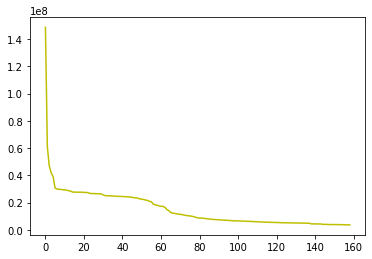

In [25]:
# normal(0.3, 0.5), BFGS, f(x) = x^4
plt.plot(li,'y')
print(res.message)

Converged (|f_n-f_(n-1)| ~= 0)


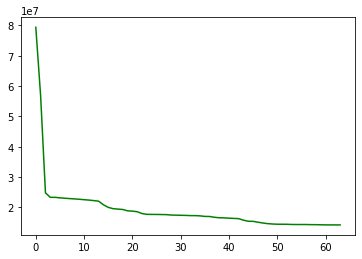

In [27]:
# normal(0.3, 0.5), TNC, f(x) = x^4
plt.plot(li,'g')
print(res.message)

Converged (|f_n-f_(n-1)| ~= 0)


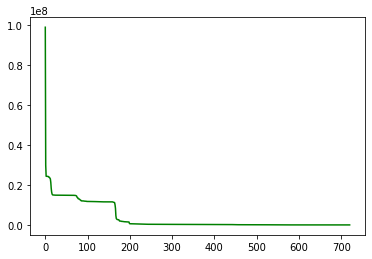

In [ ]:
plt.plot(li,'g')
# sigmoid, TNC, f(x) = x^4
print(res.message)

Desired error not necessarily achieved due to precision loss.


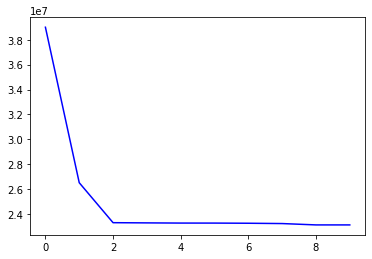

In [29]:
# normal(0.3, 0.5), CG, f(x) = x^4
plt.plot(li,'b')
print(res.message)

Maximum number of iterations has been exceeded.


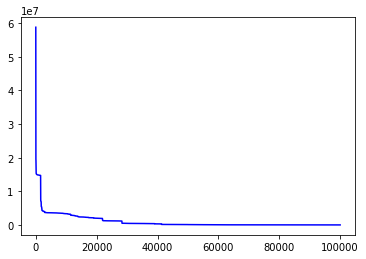

In [ ]:
plt.plot(li,'b')
# sigmoid, GC, f(x) = x^4
print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


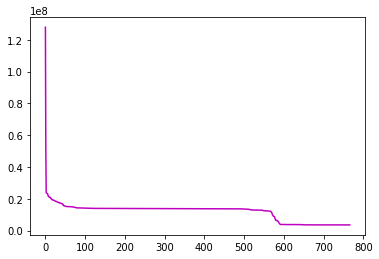

In [ ]:
# sigmoid, L-BFGS-B, f(x) = x^4
plt.plot(li,'m')
print(res.message)

b'ABNORMAL_TERMINATION_IN_LNSRCH'


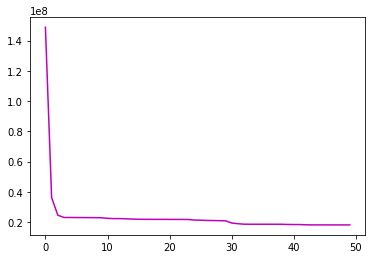

In [33]:
# normal(0.3, 0.5), L-BFGS-B, f(x) = x^4
plt.plot(li,'m')
print(res.message)

In [35]:
li1 = li # normal(0.3,0.5), L-BFGS-B, f(x) = x^4

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


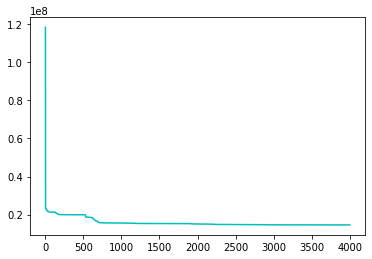

In [37]:
# normal(0.6,1), L-BFGS-B, f(x) = x^4
plt.plot(li,'c')
print(res.message)

In [ ]:
l2 =li # normal(0.6,1), L-BFGS-B, f(x) = x^4

Optimization terminated successfully.
1.094990953716253e-12


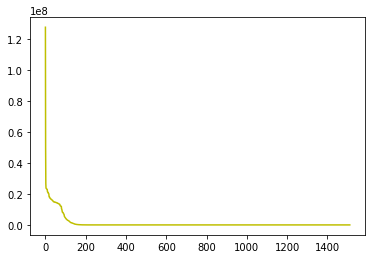

In [ ]:
# sigmoid, BFGS, f(x) = x^4
plt.plot(li,'y')
print(res.message)
print(res.fun)

Desired error not necessarily achieved due to precision loss.


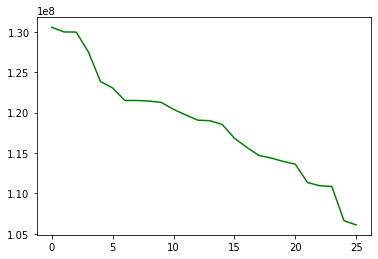

In [ ]:
plt.plot(li,'g')
# ReLu, GC, f(x) = x^4
print(res.message)

Linear search failed


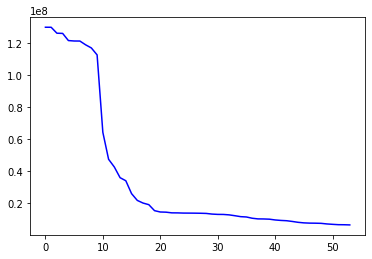

In [ ]:
plt.plot(li,'b')
# ReLu, TNC, f(x) = x^4
print(res.message)

Desired error not necessarily achieved due to precision loss.


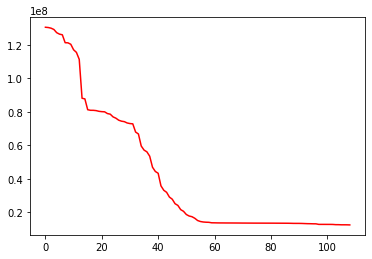

In [ ]:
# ReLu, BFGS, f(x) = x^4
plt.plot(li,'r')
print(res.message)

b'ABNORMAL_TERMINATION_IN_LNSRCH'


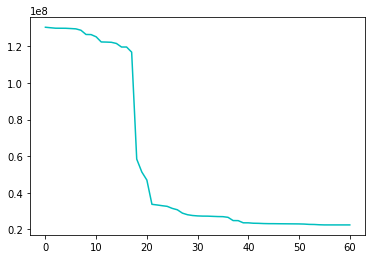

In [ ]:
# ReLu, L-BFGS-B, f(x) = x^4
plt.plot(li,'c')
print(res.message)

In [ ]:
# ReLu, BFGS, f(x) = x^4
plt.plot(li,'m')
print(res.message)

In [ ]:
data2 = pd.read_csv(os.path.join('data12 - Sheet1.csv'))

In [ ]:
xt = np.array([90,12.6,9,100,500,500,2500,0.4])

In [ ]:
# for 2 hidden layers
e = 0
p_h2t = p2hl(w1h2,w2h2,w3h2,X)    # X is training data  
"""
ph2 = predictDoubleHiddenLayer(w1h2,w2h2,w3h2,X1)    # X1 is testing data

v2 = (np.sum(a)/n)*100
print('accuracy on testing data with 2 hidden layer = {}'.format(v2))
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


"\nph2 = predictDoubleHiddenLayer(w1h2,w2h2,w3h2,X1)    # X1 is testing data\n\nv2 = (np.sum(a)/n)*100\nprint('accuracy on testing data with 2 hidden layer = {}'.format(v2))\n"

In [ ]:
el = p_h2t - np.reshape(y,(len(y),1))

In [ ]:
np.sum(np.abs(el))/len(y)

0.00211163582127701

In [ ]:
e = 0
p_h2 = p2hl(w1h2,w2h2,w3h2,X1)    # X is training data
y1 = np.reshape(y1,(len(y1),1))
print(np.sum(np.abs(p_h2-y1))/y1.shape[0]) 

0.002561359625626768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [ ]:
p_h2

array([[ 16.86935989],
       [ 21.29983154],
       [ 65.98994904],
       [ 81.63414555],
       [ 84.2678373 ],
       [ 97.39087659],
       [ 97.0767752 ],
       [118.66014039],
       [138.04944812],
       [184.80350947],
       [187.08383534]])

In [ ]:
ph2 = p2hl(w1h2,w2h2,w3h2,X)    # X is training data
print(np.sum(np.abs(ph2-y))/y.shape[0])  

2773.338277817359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [ ]:
X1.shape

(21, 8)

In [ ]:
p_h2.shape

(39, 1)

In [ ]:
y1 = y1.reshape(len(y1),1)

In [ ]:
min(d1.to_numpy()[:,8])

In [ ]:
class analtytical:

  def __init__(self):
    #dim(x) = m*p, dim (y) = 1*m, dim(w) = p*1
    return None

  def grad(self,x,y,w):
    #dim(x) = m*p, dim (y) = 1*m, dim(w) = p*1
    p = np.shape(w)[0]
    h = w.T@x.T
    d = h - y
    grad_J = d@w.T
    return grad_J

  # This function calculates the cost (J)
  def computeCost(self,x,y,w):
    #dim(x) = m*p and dim (y) = 1*m dim(w) = p*1
    J = 0    # J is cost function
    # write your code to calculate J
    m = np.shape(x)[0] #training examples ,p = no. of parameters
    p = np.shape(w)[0]
    d = w.T@x.T - y
    J = np.sum(np.square(d))/(2*m)
    return J

    def ls_secant(self,x,y,w,d):
      # d is search direction d = -grad(J). Refer class and Lab notes
      epsilon = 10**(-4) # Line search tolerance
      alpha_old = 0     # Alpha (x_i-1)
      alpha = 0.01       # initial value (x_i)
      w0 = w
      dphi_zero = d@self.grad(x,y,w)  # dphi_zero = (d^T)(grad J(w_0) # At every alpha updation loop you will have a given initial weight vector (w_0)
      dphi_curr = dphi_zero  # required for first alpha iteration
      i = 0
      while abs(dphi_curr) > (epsilon*abs(dphi_zero)) and i < 100000:
        # tolerance or looping criteria used here
        # write loop to update 
        a0 = alpha_old
        a1 = alpha
        dphi0 = dphi_curr               #dphi_i-1
        w1 = w0 - a1*d
        dphi1 = d@nlr().grad(x,y,w1)    #dphi_i
        a2 = ((a0*dphi1)-(a1*dphi0))/(dphi1-dphi0)
        alpha_old = a1
        alpha = a2
        dphi_curr = dphi1
        i = i + 1
      return alpha

  # This function optimizes the weights w_0, w_1, w_2.
  def AgradientDescent(self,x, y, w, iters):
    #dim(x) = m*p and dim (y) = 1*m dim(w) = p*1
    m = len(x)   # number of training examples
    w = w.copy() # To keep a copy of original weights
    eps = 10**(-12); # tolerance for J_history

    J_history_a = [0 for i in range(iters)]   # Use a python list to save cost in every iteration

    for i in range(iters):
      d = -1*self..grad(x,y,w) # d is search direction d = -grad(J)
      alpha = self.ls_secant(x,y,w,d) # update alpha at every iteration
  
      # Loop to update weights (w vector)
      w = w - alpha*d
      d = -self.grad(x,y,w)
      # Also save cost at every step in J_history_a
      c = self.computeCost(x,y,w)
      J_history_a[i+1] = c 
      # stopping criteria
      if abs(J_history_a[i+1] - J_history_a[i]) < eps:
        print('No. of iterations',i+1)
        break

    return w, J_history_a   


In [ ]:
a = 9

In [ ]:
b = a+9 -4